In [1]:
import kornia
import torch
import matplotlib.pyplot as plt
import time

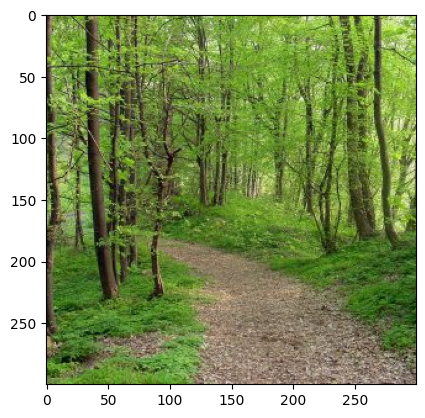

In [53]:
img_read = plt.imread('forest.jpg')
img = kornia.image_to_tensor(img_read/255)
plt.imshow(kornia.tensor_to_image(img))
img = torch.reshape(img, (1,3,img.shape[1],-1))

In [5]:
#carve the seam out of the image 
def carve(img, mins):
    B,c,h,w = img.shape
    mins = mins.int()
    new_img = torch.zeros((1,3,h,w-1))
    for i in range(h):
        new_img[0,:,i,0:mins[i]] = img[0,:,i,0:mins[i]]
        new_img[0,:,i,mins[i]:w-1] = img[0,:,i,mins[i]+1:w]
       
    return new_img

In [6]:
#main functiion to use
def MySeamCarving(img, h, w):
    start_h = img.shape[2]
    start_w = img.shape[3]
    cur = img
    t=0
    for i in range(start_w-w):
        s = time.time()
        new_cur = carve(cur, CarvingHelper (cur))
        e = time.time()
        cur = new_cur
        if i%10==0:
            print("horiz", i , " out of", start_w-w)
            print(e-s)
    cur = cur.mT
    for i in range(start_h-h):
        s = time.time()
        new_cur = carve(cur, CarvingHelper (cur))
        e = time.time()
        cur = new_cur
        if i%10==0:
            print("vertic", i , " out of", start_h-h)
            print(e-s)
    return cur.mT

In [7]:
#main function to use
def MySeamAdding(img, h, w,siz=30):
    start_h = img.shape[2]
    start_w = img.shape[3]
    cur = img
    t=0
    mins = get_mins(img, w-start_w)
    for i in range(w-start_w):
        cur = ad(cur,mins[i])
        mask = mins[i+1:,:]>=mins[i,:]
        mins[i+1:,:][mask] += 1
            
    cur = cur.mT
    mins_n = get_mins(cur, h-start_h)
    for i in range(h-start_h):
        cur = ad(cur,mins_n[i])
        mask = mins_n[i+1:,:]>=mins_n[i,:]
        mins_n[i+1:,:][mask] += 1


    return cur.mT

In [8]:
#to add a seam to the image
edge = 0
def ad(img,mins):
    global edge
    mins = mins.int()
    B,c,h,w = img.shape
    new_img = torch.zeros((1,3,h,w+1))  
    for i in range(h):
        new_img[0,:,i,0:mins[i]+1] = img[0,:,i,0:mins[i]+1]
        new_img[0,:,i,mins[i]+2:] = img[0,:,i,mins[i]+1:]
        if mins[i]+1<w:
            new_img[0,:,i,mins[i]+1] = (img[0,:,i,mins[i]] + img[0,:,i,mins[i]+1])/2
        else:
            edge+=1
            new_img[0,:,i,mins[i]+1] = (img[0,:,i,mins[i]-1] + img[0,:,i,mins[i]])/2
    return new_img

In [9]:
# needed for seam insertion
# finds "n" seams. 
# removing best seam, then looks for next best seam, etc
# return a tensor of seem indexes
def get_mins(img,n):
    B,c,h,w = img.shape
    mins = torch.zeros((n,h))
    cur = img

    r = torch.tensor(range(w))
    r = torch.tile(r,(h,1))
    out = r.detach().clone()
    
    for i in range(n):
        local_min = (CarvingHelper (cur)).int()

        if i%10==0:
            print(i, "/", n)
        
        mins[i] = r[range(h),local_min]
        mask = torch.ones((h,w-i), dtype=torch.bool)
        mask[range(h), local_min] = False
        r = r[mask].reshape(h, w-1-i)
            
        cur = carve(cur, local_min)
    return mins

In [10]:
img.shape

torch.Size([1, 3, 1151, 1728])

In [105]:
a = MySeamCarving(img, 1151 ,1200)
plt.imsave("york_1200.jpg",kornia.tensor_to_image(a))
b = MySeamCarving(img, 720 ,1728)
plt.imsave("york_720.jpg",kornia.tensor_to_image(b))

In [102]:
#find the seam
def CarvingHelper (img):
    out = kornia.filters.spatial_gradient(img)
    img_grad_mag_3C = torch.sqrt(torch.square(out[:,:,0,:,:]) + torch.square(out[:,:,1,:,:]))
    E = (img_grad_mag_3C[:,0,:,:] + img_grad_mag_3C[:,1,:,:] + img_grad_mag_3C[:,2,:,:])

    B,h,w = E.shape
    
    M = torch.zeros((h,w + 2))
    M[0,1:w+1] = E[0,0,:]
    M[:,0] = float('inf')
    M[:,w+1] = float('inf')

    for i in range(0,h-1):
        s = torch.stack((M[i,:].roll(-1),M[i,:],M[i,:].roll(1)))
        M[i+1,1:w+1] = E[0,i+1,:] + torch.min(s[:,1:w+1], dim=0)[0]
    
  
    #find the seams index by backtracking
    mins = torch.zeros(h).int()
    mins[h-1] = torch.argmin(M[h-1,:])
    for i in range(h-2,-1,-1):
        if mins[i]==w-1:
            min_ind = torch.argmin(M[i,mins[i+1]-1:mins[i+1]+1]) - 1
        elif mins[i]==0:
            min_ind = torch.argmin(M[i,mins[i+1]:mins[i+1]+2])
        else:
            min_ind = torch.argmin(M[i,mins[i+1]-1:mins[i+1]+2]) - 1
        mins[i] = min_ind + mins[i+1]
    return mins.int()

tensor([[1.0000, 0.3476, 0.1815, 0.5564, 0.4863, 0.2290, 0.2639, 0.1289, 1.0000]])